# CNN vs SVM CAPTCHA Classifier

### Import necessary libraries

In [ ]:
! pip install claptcha

In [ ]:
import cv2                              # OpenCV for computer vision tasks
import joblib                           # Joblib for efficient Python object serialization
import os                               # Operating system-related functions
import numpy as np                      # NumPy for numerical operations
import pandas as pd                     # Pandas for data manipulation and analysis
import random                           # Random number generation
import requests                         # HTTP requests library
import matplotlib.pyplot as plt
import seaborn as sns
import shutil                           # File operations (copy, move, etc.)
import string                           # String manipulation functions

from claptcha import Claptcha           # Claptcha for generating CAPTCHA images
from google.colab.patches import cv2_imshow
from keras.models import Sequential     # Keras deep learning framework for neural networks
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization  # Keras layers for building neural networks
from keras.preprocessing.image import ImageDataGenerator  # Keras image data augmentation
from keras.utils import plot_model
from PIL import Image                   # Python Imaging Library for image processing
from skimage.feature import hog         # Histogram of Oriented Gradients feature extraction
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve  # scikit-learn for machine learning tools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Model evaluation metrics
from sklearn.svm import SVC             # Support Vector Machine classifier

### Define Constants

In [ ]:
train_dir = "train_dir"                                       # Directory path for the training dataset
font = "https://github.com/opensourcedesign/fonts/raw/master/gnu-freefont_freemono/FreeMono.ttf"
font_path = font.split("/")[-1]                               # Font filename from the URL
captcha_length = 4                                            # Number of characters in a CAPTCHA
char_width = 37.5                                             # Width of each character in pixels
image_size = (int(captcha_length * char_width), 90)           # Dimensions of CAPTCHA image
image_margin = (0, 0)                                         # Margins added to the CAPTCHA image
total_images = 100                                           # Total number of CAPTCHA images to generate
test_set_size = int(0.15 * total_images)                      # Size of the test dataset
val_set_size = int(0.2 * (total_images - test_set_size))      # Size of the validation dataset
svm_model = 'svm_model.pkl'                                   # File name for saving the SVM model
cnn_model = 'cnn_model.hdf5'                                  # File name for saving the CNN model

class_mapping = [str(i) for i in range(10)]                   # Mapping of numeric characters (0-9)
class_mapping.extend([chr(ord('A') + i) for i in range(26)])  # Mapping of uppercase alphabetic characters (A-Z)

## 1. CAPTCHA Generation and Preprocessing
In this section, we will generate CAPTCHAs and preprocess them for training a machine learning model. We'll follow these steps:


### 1.1 **Font Download**: Download a font for creating CAPTCHAs.
We need a specific font to create our CAPTCHAs. We'll download the font from a public source.

In [ ]:
# Helper function to download the font
def download_font(font_url, font_path):
    if not os.path.isfile(font_path):
        response = requests.get(font)
        if response.status_code == 200:
            with open(font_path, 'wb') as font_file:
                font_file.write(response.content)
        else:
            raise Exception("Failed to download the font file.")

download_font(font, font_path)

### 1.2 **CAPTCHA Generation**: Generate random CAPTCHA text and create CAPTCHA images.

In [ ]:
def random_string(length):
    """Helper function to generate random strings"""
    rndLetters = (random.sample(string.ascii_uppercase + string.digits, length))
    return "".join(rndLetters)

In [ ]:
def process_captcha_image(image):
    """Function to preprocess individual letters of CAPTCHA images"""
    gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.threshold(gray_scale, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    return image

In [ ]:
shutil.rmtree(train_dir)

In [ ]:
def cnn_preprocessing(image):
    resized = cv2.resize(image, (32,32))
    img = np.expand_dims(resized, axis=2)
    return np.expand_dims(img, axis=0)

In [ ]:
def slice_image(image):
    sliced_image = []
    for i in range(captcha_length):
        # Extract and process individual characters from the CAPTCHA
        start_col = int((image_margin[0] / 2) + (char_width * i))
        end_col = int(start_col + char_width)
        sliced_image.append(image[0:image_size[1], start_col:end_col])
    return sliced_image

In [ ]:
def saveimage(letter_text,letter_image, value, folder):
    '''A function to save the images'''
    os.makedirs(folder, exist_ok=True)  # Create folder
    path = os.path.join(folder, letter_text)
    if not os.path.exists(path):
        os.makedirs(path)
    p = os.path.join(path, f"{value}.png")
    cv2.imwrite(p, letter_image)

In [ ]:
data = []             # List to store feature vectors for each character
labels = []           # List to store corresponding labels (character classes)
val_data = []         # List to store validation data for CNN
test_data = {}        # Dictionary to store test data for evaluation

for i in range(total_images):
    # Generate a random string as the CAPTCHA text
    text = random_string(captcha_length)

    # Create a CAPTCHA image using the Claptcha library
    c = Claptcha(text, font_path, image_size, resample=Image.BICUBIC, noise=0.2)
    c.margin = image_margin
    _, image = c.image

    # Process the CAPTCHA image to prepare it for feature extraction
    processed_image_array = process_captcha_image(np.array(image))

    if i < test_set_size:  # If we're building the test set
        test_data[text + str(i)] = np.array(image)
    else:
        for index, sliced_image in enumerate(slice_image(processed_image_array)):
            data.append(hog(sliced_image, pixels_per_cell=(8, 8)))  # Extract HOG features
            labels.append(class_mapping.index(text[index]))         # Encode the label

            if i < test_set_size + val_set_size:  # If building the validation set
                val_data.append(cnn_preprocessing(sliced_image))
            else:                                 # If building the training set
                saveimage(text[index], sliced_image, f'{text}[{index}]', train_dir)

## 2. Train the SVM Classifier

### 2.1 Split the data into training and testing sets
Split the dataset into training and testing sets, train a Support Vector Machine (SVM) classifier, and evaluate its performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data), labels, test_size=0.2, random_state=42)

### 2.2 Hyperparameter Tuning
To find the optimal combination of hyperparameters for your SVM model, we can use techniques like grid search or random search.

In [ ]:
# Define a parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create the grid search model
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(X_train[:2000], y_train[:2000])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


In [ ]:
# Define a parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create the grid search model
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


### 2.3 Initialize, train, and evaluate  the SVM classifier

In [ ]:
# Create an SVM classifier
svm_clf = SVC(kernel='poly', gamma=1, C=0.1)

# Train the SVM on your training data
svm_clf.fit(X_train, y_train)

# Save the trained SVM model to a file
joblib.dump(svm_clf, svm_model)

y_pred = svm_clf.predict(X_test)

# Calculate accuracy and generate a classification report
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_mapping))

Accuracy: 0.957843137254902
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       116
           1       0.90      0.97      0.93       125
           2       0.98      0.97      0.97       115
           3       1.00      0.96      0.98       116
           4       0.94      1.00      0.97       123
           5       0.94      0.95      0.95       108
           6       0.97      0.98      0.98       100
           7       0.98      0.96      0.97       121
           8       0.95      0.98      0.96       123
           9       0.92      1.00      0.96       113
           A       0.98      0.95      0.97       102
           B       0.96      0.95      0.96       105
           C       0.99      0.98      0.99       136
           D       0.94      0.87      0.91       111
           E       0.94      0.96      0.95       122
           F       0.93      0.99      0.96       111
           G       0.92      

In [ ]:
svm_clf = joblib.load(svm_model)

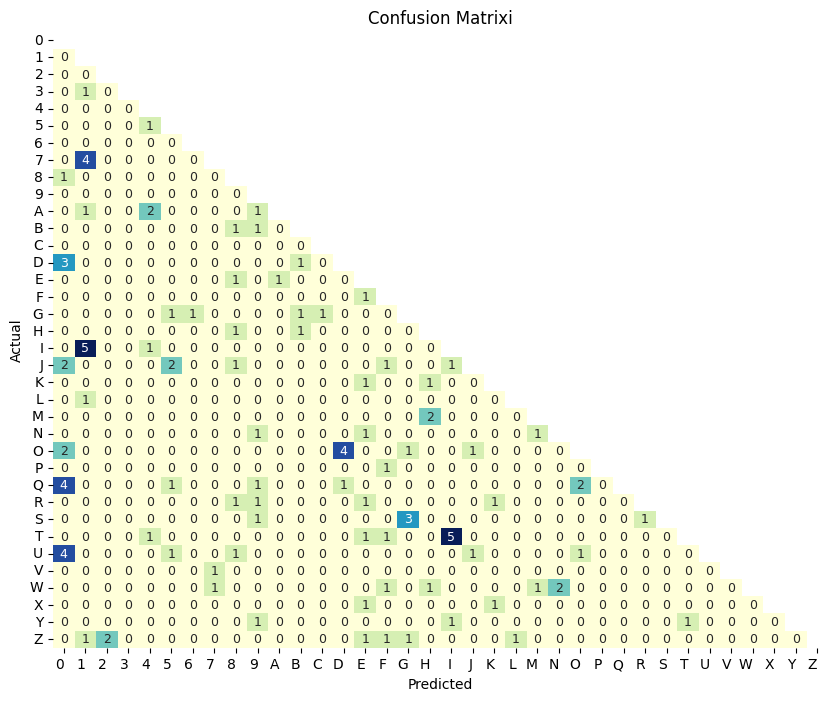

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Set diagonal elements to zero (exclude the diagonal)
np.fill_diagonal(conf_matrix, 0)

# Create a mask to hide the upper triangle (diagonal)
mask = np.triu(np.ones_like(conf_matrix, dtype=bool))

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, cmap='YlGnBu', annot=True, fmt='d', xticklabels=class_mapping, yticklabels=class_mapping, mask=mask, cbar=False)

# Set x-axis and y-axis labels
class_labels = [class_mapping[i] for i in range(len(class_mapping))]
ax.set_xticklabels(class_labels, rotation=0, ha='right')
ax.set_yticklabels(class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Widen the columns by setting the font size
for text in ax.texts:
    text.set_size(9)

# Display the plot
plt.show()

## 3. Train the CNN Classifier

### 3.1 Data Augmentation
Augment the training data to improve model generalization.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,  # Randomly shift images vertically by up to 10%
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Randomly zoom in by up to 20%
    horizontal_flip=False,  # Don't flip horizontally
    fill_mode='nearest'  # Fill missing pixels with the nearest value
)

### 3.2 Data Generation
Generate training data from the 'train_dir' directory.

In [ ]:
# Training data generation - from directory train_dir
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    class_mode = 'categorical',color_mode='grayscale'
    )

Found 16296 images belonging to 36 classes.


### 3.3 Define, Compile, and Fit a Sequential CNN model

In [ ]:
cnn_clf = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(36, activation='softmax')
])

# Compile the model with adjusted learning rate
cnn_clf.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

## Fitting the model
history = cnn_clf.fit(training_set,
                      batch_size=64,
                      epochs=10)

Epoch 1/10
510/510 [==============================] - 47s 88ms/step - loss: 2.1713 - accuracy: 0.4022
Epoch 2/10
510/510 [==============================] - 40s 79ms/step - loss: 1.0940 - accuracy: 0.6858
Epoch 3/10
510/510 [==============================] - 39s 76ms/step - loss: 0.7432 - accuracy: 0.7793
Epoch 4/10
510/510 [==============================] - 42s 82ms/step - loss: 0.5751 - accuracy: 0.8274
Epoch 5/10
510/510 [==============================] - 42s 82ms/step - loss: 0.4865 - accuracy: 0.8516
Epoch 6/10
510/510 [==============================] - 43s 84ms/step - loss: 0.4197 - accuracy: 0.8717
Epoch 7/10
510/510 [==============================] - 44s 86ms/step - loss: 0.3641 - accuracy: 0.8859
Epoch 8/10
510/510 [==============================] - 43s 85ms/step - loss: 0.3540 - accuracy: 0.8879
Epoch 9/10
510/510 [==============================] - 41s 80ms/step - loss: 0.3289 - accuracy: 0.8995
Epoch 10/10
510/510 [==============================] - 42s 82ms/step - loss: 0.302

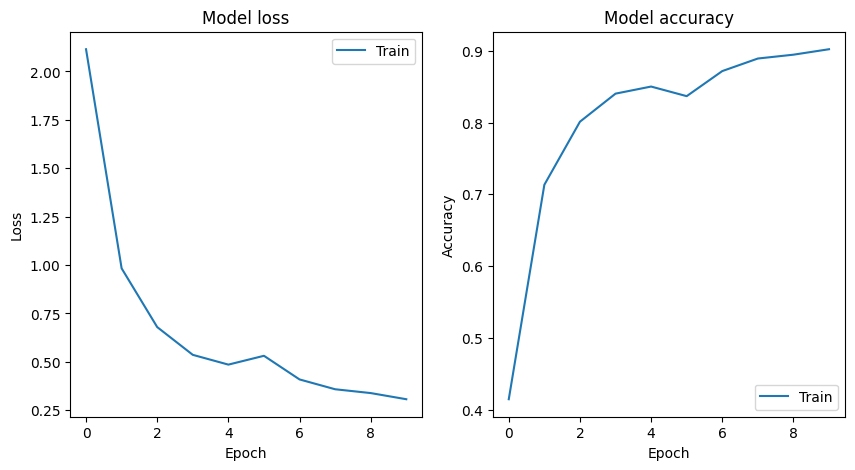

In [ ]:
# Plot training loss values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# Plot training accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')

plt.show()

In [ ]:
## Hierarchical Data format file to save the model. So that we dont have to run the entire sequence of program again.
cnn_clf.save(cnn_model)

In [ ]:
with open("model_summary.txt", "w") as f:
    cnn_clf.summary(print_fn=lambda x: f.write(x + '\n'))

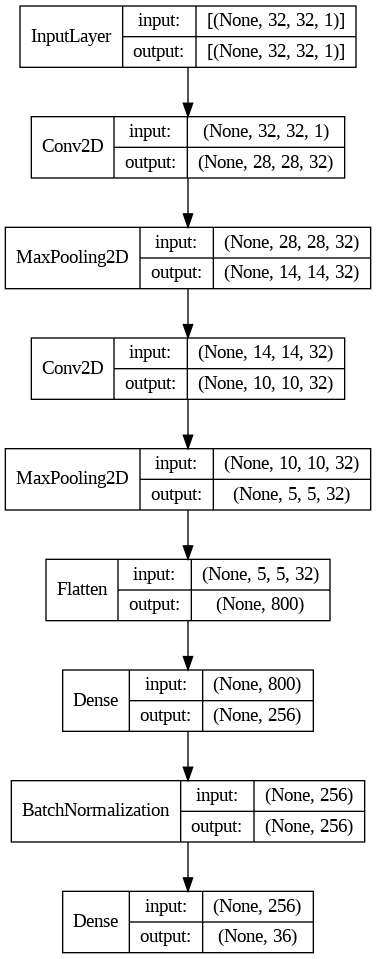

In [ ]:
plot_model(
    cnn_clf,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
)

### 3.4 Evaluate the CNN model

In [ ]:
val_data_batch = np.stack(val_data, axis=0).squeeze()

# Add a batch dimension
val_data_batch = np.expand_dims(val_data_batch, axis=-1)

predict_x = cnn_clf.predict(val_data_batch)
predicted_classes = np.argmax(predict_x, axis=1)

# Calculate accuracy and generate a classification report
accuracy = accuracy_score(labels[:val_set_size * 4], predicted_classes)
print(f"Accuracy: {accuracy}")

print(classification_report(labels[:val_set_size * 4], predicted_classes, target_names=class_mapping))

128/128 [==============================] - 2s 14ms/step
Accuracy: 0.9754901960784313
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       122
           1       0.95      0.98      0.96       131
           2       1.00      0.98      0.99       109
           3       1.00      0.98      0.99       122
           4       0.98      0.98      0.98       114
           5       0.98      0.98      0.98       107
           6       0.99      0.99      0.99       138
           7       1.00      0.98      0.99        97
           8       0.87      1.00      0.93       109
           9       0.98      0.98      0.98        95
           A       0.98      0.97      0.98       126
           B       0.97      0.95      0.96       111
           C       0.98      0.99      0.99       123
           D       0.97      0.91      0.94       111
           E       0.98      0.99      0.99       111
           F       0.99      0.98      0.99       

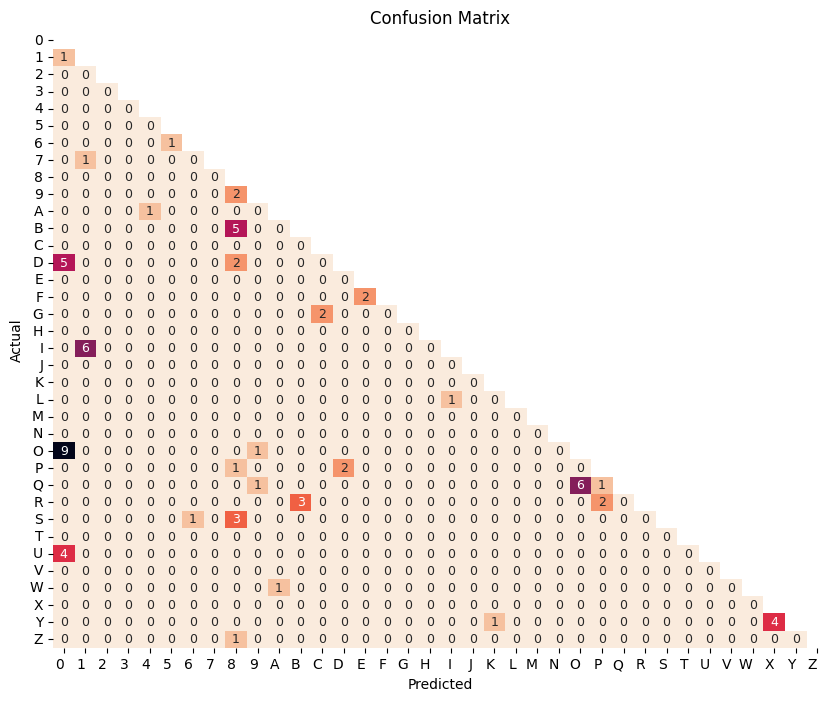

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(labels[:val_set_size * 4], predicted_classes)

# Create a mask to hide the upper triangle (diagonal)
mask = np.triu(np.ones_like(conf_matrix, dtype=bool))

# Create a custom colormap where 0 values are white and other values use a colormap
cmap = sns.cm.rocket_r

# Create a heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_mapping, yticklabels=class_mapping, cmap=cmap, mask=mask, cbar=False)

# Set x-axis and y-axis labels
class_labels = [class_mapping[i] for i in range(len(class_mapping))]
ax.set_xticklabels(class_labels, rotation=0, ha='right')
ax.set_yticklabels(class_labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Widen the columns by setting the font size
for text in ax.texts:
    text.set_size(9)

# Display the plot
plt.show()

## 4. Test the models on the test data

In [ ]:
#Get list of all Test files from the mapping of the classes
d = training_set.class_indices
dict_class = {v:k for k,v in d.items()}

In [ ]:
# Counter to count the number of correct predictions
cnn_count = 0
svm_count = 0

## Predict function to test all the images from the Test_data directory
for value, image in test_data.items():
    value = value[:4]
    cnn_combine = []
    svm_combine = []
    #Slicing the image
    for sliced_image in slice_image(process_captcha_image(image)):
        feature_vector = hog(sliced_image, pixels_per_cell=(8, 8))
        class_probs = cnn_clf.predict(cnn_preprocessing(sliced_image))
        svm_combine.append(dict_class[svm_clf.predict([feature_vector])[0]])
        cnn_combine.append(dict_class[np.argmax(class_probs, axis=1)[0]])

    cnn_predict = ''.join(cnn_combine)
    svm_predict = ''.join(svm_combine)
    print(f'CNN prediction: {cnn_predict}')
    print(f'SVM prediction: {svm_predict}')
    print(f'Actual value  : {value}')
    print("------------")
    # Increment the counter if the predicted and actual captcha letters match
    if value == cnn_predict:
        cnn_count += 1
    if value == svm_predict:
        svm_count += 1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
CNN prediction: YP3J
SVM prediction: YP3J
Actual value  : YP3J
------------
1/1 [==============================] - 0s 28ms/step
CNN prediction: WK75
SVM prediction: WK75
Actual value  : WK75
------------
1/1 [==============================] - 0s 24ms/step
CNN prediction: ZMK4
SVM prediction: ZMK4
Actual value  : ZMK4
------------
1/1 [==============================] - 0s 27ms/step
CNN prediction: 40N3
SVM prediction: 40N3
Actual value  : 40N3
------------
1/1 [==============================] - 0s 28ms/step
CNN prediction: Q4KF
SVM prediction: Q4KF
Actual value  : Q4KF
------------
1/1 [==============================] - 0s 30ms/step
CNN prediction: PFKO
SVM prediction: PFKO
Actual value  : PFKO
------------
1/1 [==============================] - 0s 30ms/step
CNN prediction: 5S9X
SVM prediction: 5S9X
Actual value  : 5S9X
------------
1/1 [==============================] - 0s 31ms/step
C

In [ ]:
# Number of correct predictions is stored in count variable
print(f'CNN accuracy: {cnn_count / test_set_size}')
print(f'SVM accuracy: {svm_count / test_set_size}')

CNN accuracy: 0.9166666666666666
SVM accuracy: 0.8755555555555555
